### Signal Estimation Tutorial | Model Profiling | Compressed Resnet34

#### Step 1 - Import relevant modules

In [18]:
from __future__ import division
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torchvision
import torchvision.transforms.functional as TF
import pandas as pd
from PIL import Image
from IPython.display import Image as IPImage
torch.cuda.set_device(0)
from torchsummary import summary
from untangle import UntangleAI
untangle_ai = UntangleAI()

#### Step 2 - Define transforms to be applied to each input image

In [19]:
class MyContrastTransform:

    def __init__(self):
        pass

    def __call__(self, x):
        return TF.adjust_contrast(x, 5)

class MyNegativeTransform:
    
    def __init__(self):
        pass
    
    def __call__(self,x):
        return torch.ones(x.shape)-x

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        MyContrastTransform(),
        transforms.ToTensor(),
        MyNegativeTransform(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        MyContrastTransform(),
        transforms.ToTensor(),
        MyNegativeTransform(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#### Step 3 - Define signal estimation arguments and set the module to eval phase

In [41]:
class Args:
    mname = 'resnet34_cmp'
    batch_size = 32
    num_classes = 6
    img_size = (3,224,224)
    input_tensor = torch.randn(1,3,224,224) # provide your own input tensor
    input_tensor_true = torch.randn(224,224,3) # provide your own true input tensor / ndarray / PIL Image Obj
    data_class = None # list of class indices, or `None` to estimate all classes
    mode = 'estimate' # one of `estimate`, `attribute`
    topk = 2
    cmap = 'seismic'
    json = False
    hm_diff = 'joint'
    use_smoothgrad = False
    stdev_spread = 0.05 # for smoothGrad only. Ignored if `use_smoothgrad=False`
    mean = 0.0 # for smoothGrad only.  Ignored if `use_smoothgrad=False`
    nsamples = 25 # for smoothGrad only.  Ignored if `use_smoothgrad=False`
    magnitude = False # for smoothGrad only.  Ignored if `use_smoothgrad=False`
    
args = Args()
model_ft = torch.load('Channel_Pruned_0.99_NEU_CLS_no_accuracy_drop.pkl')
model_ft = model_ft.eval()
if (torch.cuda.is_available()):
    model_ft = model_ft.cuda()    
keys = [str(item) for item in range(args.num_classes)]
ID2Name_Map = dict(zip(keys, keys)) # backward compatibility to existing codebase

#### Step 4 - Estimate signals per class

In [4]:
dataroot = 'NEU-CLS_New/train'
module_path = os.path.realpath('.')
model_signal_path = os.path.join(module_path, 'model_signal_data/')
signal_store_path = os.path.join(model_signal_path, '{}_signal'.format(args.mname))
def train_loader_fun(class_i):
    loader = untangle_ai.load_from_dir_per_class(dataroot, data_class=class_i, batch_size=128, transform=data_transforms['train'], shuffle=False,
                                get_paths=False)
    return(loader)

device = torch.device("cuda")
model_ft.to(device)
untangle_ai.estimate_signals(model_ft, signal_store_path, train_loader_fun, args)

  0%|          | 0/2 [00:00<?, ?it/s]

Estimating signals for class: `0`


  0%|          | 0/2 [00:00<?, ?it/s]

signals saved in path: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_0.pkl
Estimating signals for class: `1`


  0%|          | 0/2 [00:00<?, ?it/s]

signals saved in path: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_1.pkl
Estimating signals for class: `2`


  0%|          | 0/2 [00:00<?, ?it/s]

signals saved in path: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_2.pkl
Estimating signals for class: `3`


  0%|          | 0/2 [00:00<?, ?it/s]

signals saved in path: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_3.pkl
Estimating signals for class: `4`


  0%|          | 0/2 [00:00<?, ?it/s]

signals saved in path: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_4.pkl
Estimating signals for class: `5`


100%|██████████| 2/2 [00:05<00:00,  3.00s/it]


signals saved in path: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_5.pkl


#### Transforms for input tensor and the true image

In [21]:
results_path = os.path.join(module_path, 'results')

img_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224)])

tensor_transform = transforms.Compose([
        MyContrastTransform(),
        transforms.ToTensor(),
        MyNegativeTransform(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#### Step 5.1 - Signal Attribution profile | Correctly Classified Images

##### Example 1

In [6]:
img_path = "NEU-CLS_New/val/Rs/RS_32.bmp"

if(not os.path.exists(img_path)):
    raise FileNotFoundError(img_path)
inp_image = Image.open(img_path)
inp_image = inp_image.convert("RGB")
crop_inp_image = img_transform(inp_image)
input_tensor = tensor_transform(crop_inp_image)
input_tensor = input_tensor.unsqueeze(0)
if (torch.cuda.is_available()):
    input_tensor = input_tensor.cuda()

img_name = img_path.split('/')[-1].split('.')[0].strip()
out_prefix = os.path.join(results_path, '{}_{}_signals'.format(args.mname, img_name))
gradients = untangle_ai.attribute_signals(model_ft, input_tensor, crop_inp_image, signal_store_path, ID2Name_Map, args, out_prefix)

Top-2 class(es): ['4', '2']
Top-2 indices(s): [4, 2]
Top-2 logit(s): [6.417037, 1.2531148]
Top-2 probs(s): [0.99292374, 0.0056787524]
----------------------------------------------------------------------
     Signal visualization for class: 4 [4]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_4.pkl
----------------------------------------------------------------------
     Signal visualization for class: 2 [2]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_2.pkl
class_0 specific heatmap saved in path: `/home/jupyter/results/resnet34_cmp_RS_32_signals_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/resnet34_cmp_RS_32_signals_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/resnet34_cmp_RS_32_signals_diff_

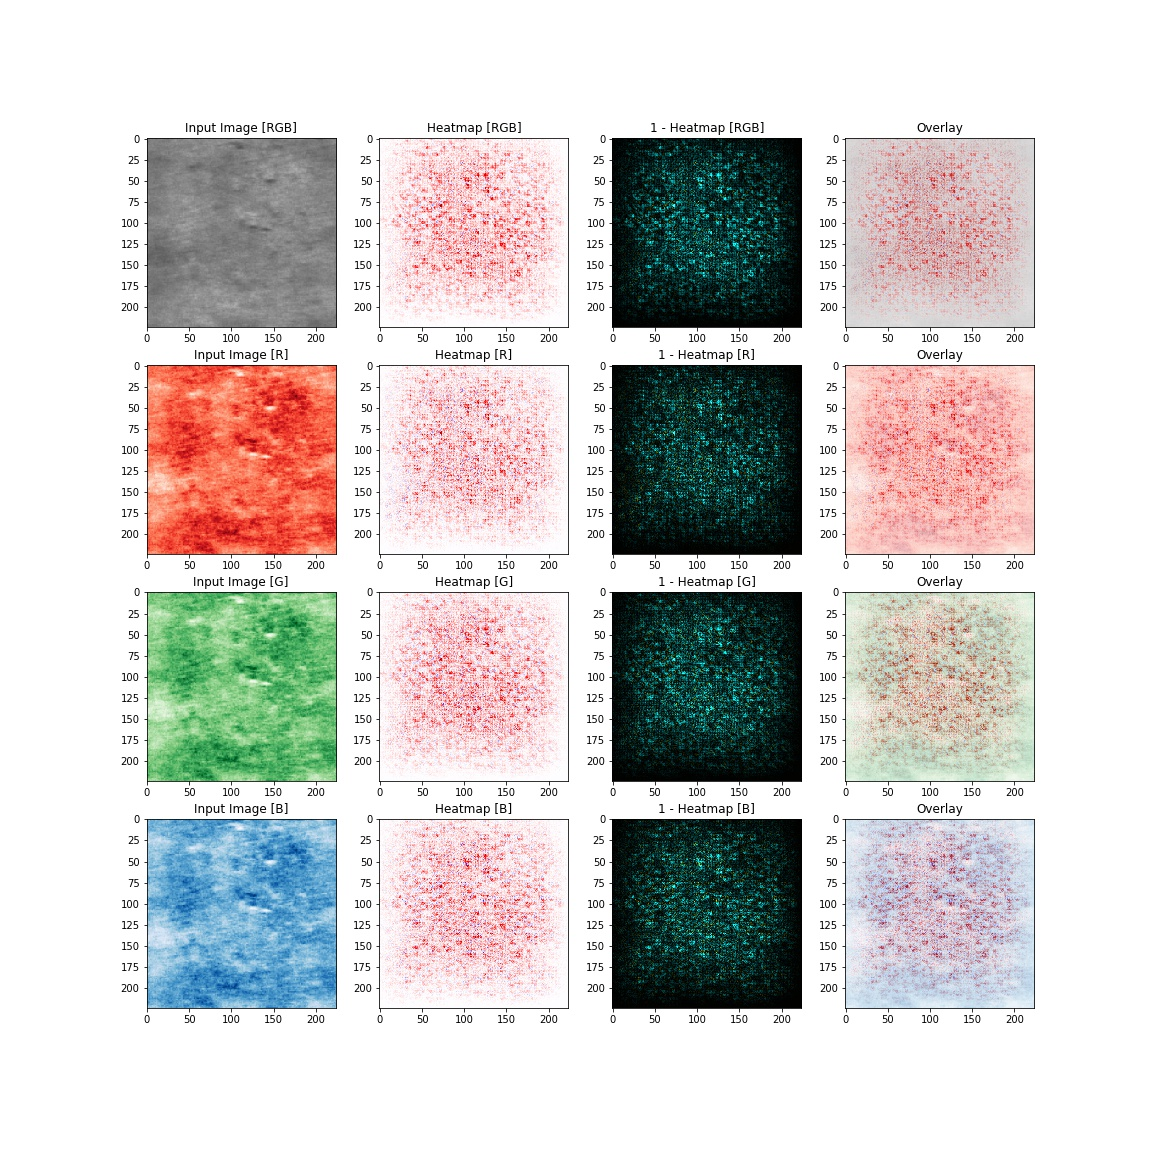

In [7]:
IPImage('/home/jupyter/results/lenet_RS_32_signals_class_0.JPEG')

In [8]:
%%timeit
gradients = untangle_ai.attribute_signals(model_ft, input_tensor, crop_inp_image, signal_store_path, ID2Name_Map, args, out_prefix)

Top-2 class(es): ['4', '2']
Top-2 indices(s): [4, 2]
Top-2 logit(s): [6.417037, 1.2531148]
Top-2 probs(s): [0.99292374, 0.0056787524]
----------------------------------------------------------------------
     Signal visualization for class: 4 [4]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_4.pkl
----------------------------------------------------------------------
     Signal visualization for class: 2 [2]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_2.pkl
class_0 specific heatmap saved in path: `/home/jupyter/results/resnet34_cmp_RS_32_signals_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/resnet34_cmp_RS_32_signals_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/resnet34_cmp_RS_32_signals_diff_

##### Example 2

In [9]:
img_path = "NEU-CLS_New/val/Cr/Cr_59.bmp"

if(not os.path.exists(img_path)):
    raise FileNotFoundError(img_path)
inp_image = Image.open(img_path)
inp_image = inp_image.convert("RGB")
crop_inp_image = img_transform(inp_image)
input_tensor = tensor_transform(crop_inp_image)
input_tensor = input_tensor.unsqueeze(0)
if (torch.cuda.is_available()):
    input_tensor = input_tensor.cuda()

img_name = img_path.split('/')[-1].split('.')[0].strip()
out_prefix = os.path.join(results_path, '{}_{}_signals'.format(args.mname, img_name))
gradients = untangle_ai.attribute_signals(model_ft, input_tensor, crop_inp_image, signal_store_path, ID2Name_Map, args, out_prefix)

Top-2 class(es): ['0', '3']
Top-2 indices(s): [0, 3]
Top-2 logit(s): [7.237533, 3.6103566]
Top-2 probs(s): [0.9720318, 0.02584745]
----------------------------------------------------------------------
     Signal visualization for class: 0 [0]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_0.pkl
----------------------------------------------------------------------
     Signal visualization for class: 3 [3]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_3.pkl
class_0 specific heatmap saved in path: `/home/jupyter/results/resnet34_cmp_Cr_59_signals_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/resnet34_cmp_Cr_59_signals_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/resnet34_cmp_Cr_59_signals_diff_cla

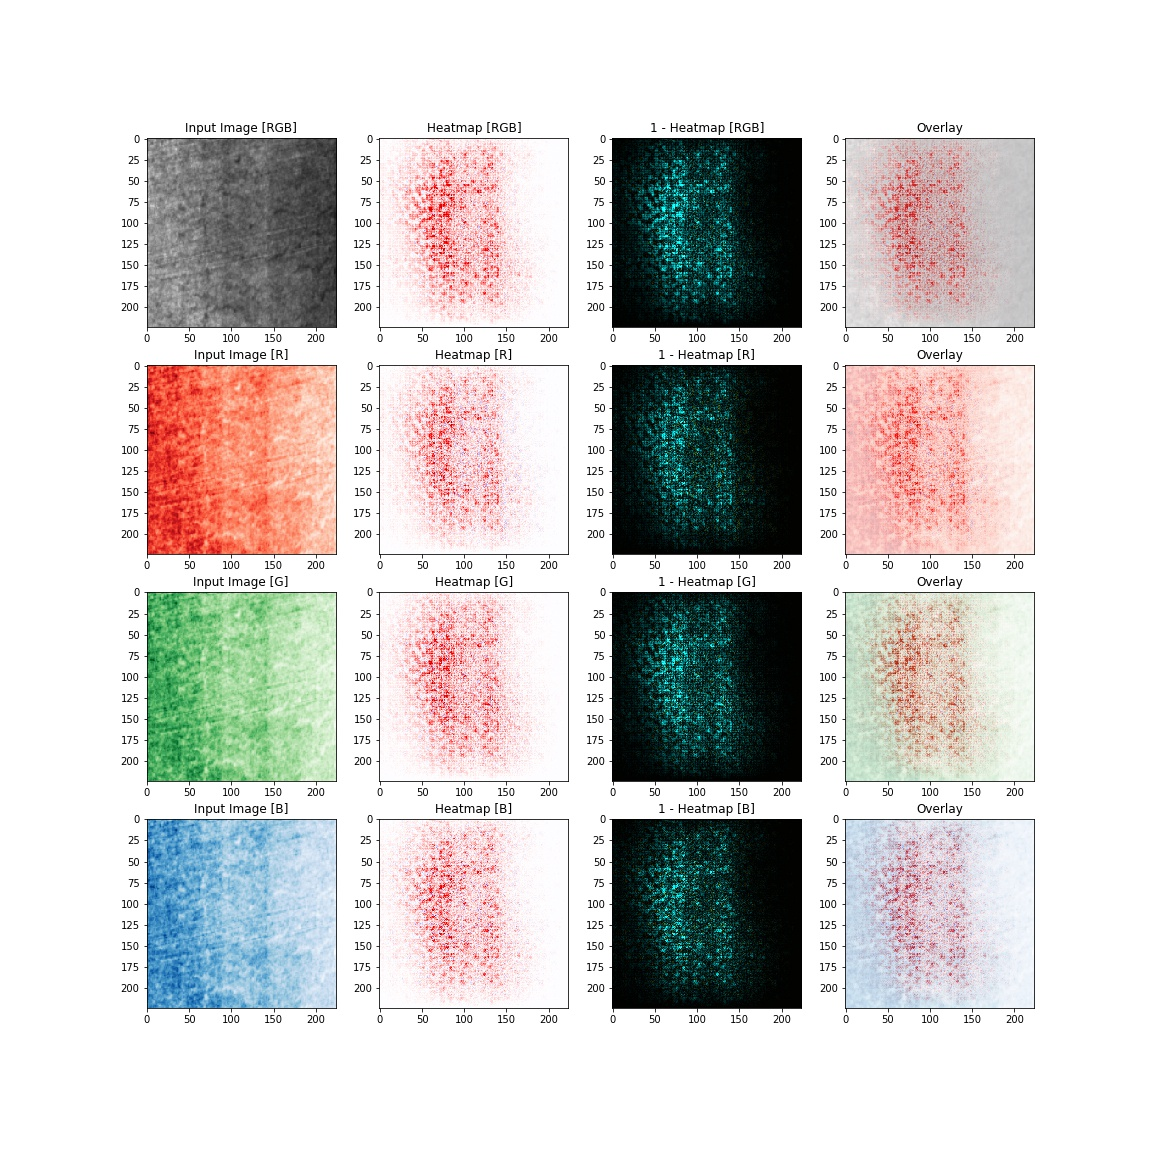

In [10]:
IPImage('/home/jupyter/results/lenet_Cr_59_signals_class_0.JPEG')

In [11]:
%%timeit
gradients = untangle_ai.attribute_signals(model_ft, input_tensor, crop_inp_image, signal_store_path, ID2Name_Map, args, out_prefix)

Top-2 class(es): ['0', '3']
Top-2 indices(s): [0, 3]
Top-2 logit(s): [7.237533, 3.6103566]
Top-2 probs(s): [0.9720318, 0.02584745]
----------------------------------------------------------------------
     Signal visualization for class: 0 [0]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_0.pkl
----------------------------------------------------------------------
     Signal visualization for class: 3 [3]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_3.pkl
class_0 specific heatmap saved in path: `/home/jupyter/results/resnet34_cmp_Cr_59_signals_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/resnet34_cmp_Cr_59_signals_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/resnet34_cmp_Cr_59_signals_diff_cla

#### Step 5.2 - Signal Attribution profile | Uncertain Images

##### Example 1

In [22]:
img_path = 'NEU-CLS_New/val/PS/PS_86.bmp'
if(not os.path.exists(img_path)):
    raise FileNotFoundError(img_path)
inp_image = Image.open(img_path)
inp_image = inp_image.convert("RGB")
crop_inp_image = img_transform(inp_image)
input_tensor = tensor_transform(crop_inp_image)
input_tensor = input_tensor.unsqueeze(0)
if (torch.cuda.is_available()):
    input_tensor = input_tensor.cuda()

img_name = img_path.split('/')[-1].split('.')[0].strip()
out_prefix = os.path.join(results_path, '{}_{}_signals'.format(args.mname, img_name))
gradients = untangle_ai.attribute_signals(model_ft, input_tensor, crop_inp_image, signal_store_path, ID2Name_Map, args, out_prefix)

Top-2 class(es): ['2', '3']
Top-2 indices(s): [2, 3]
Top-2 logit(s): [5.1258116, 1.7317984]
Top-2 probs(s): [0.9351943, 0.03139791]
----------------------------------------------------------------------
     Signal visualization for class: 2 [2]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_2.pkl
----------------------------------------------------------------------
     Signal visualization for class: 3 [3]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_3.pkl
class_0 specific heatmap saved in path: `/home/jupyter/results/resnet34_cmp_PS_86_signals_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/resnet34_cmp_PS_86_signals_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/resnet34_cmp_PS_86_signals_diff_cl

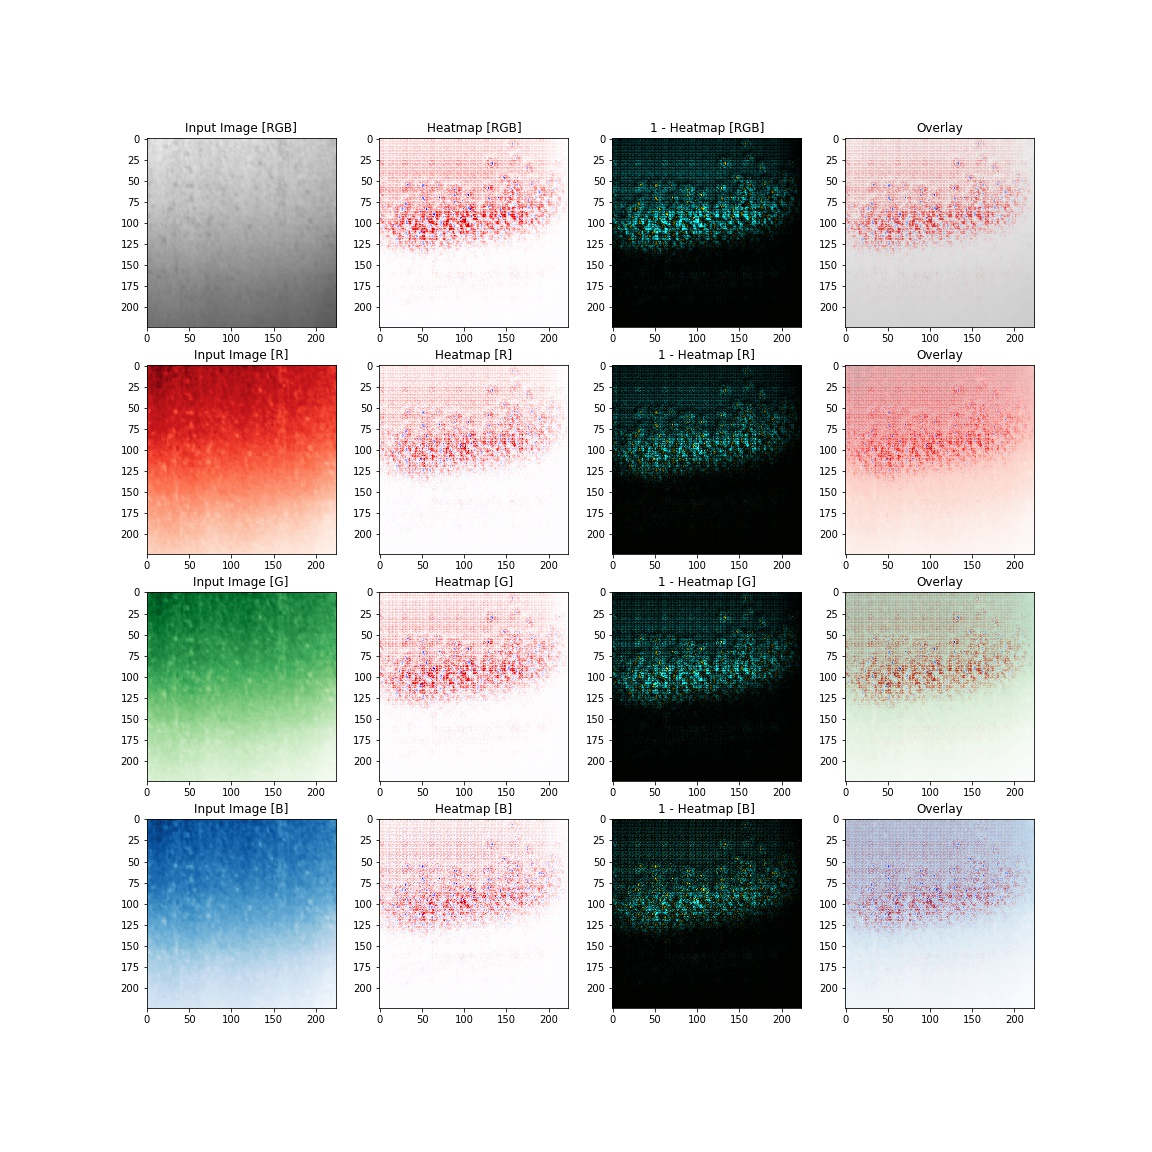

In [23]:
IPImage('/home/jupyter/results/lenet_PS_86_signals_class_0.JPEG')

##### Example 2

In [24]:
img_path = 'NEU-CLS_New/val/Rs/RS_56.bmp'

if(not os.path.exists(img_path)):
    raise FileNotFoundError(img_path)
inp_image = Image.open(img_path)
inp_image = inp_image.convert("RGB")
crop_inp_image = img_transform(inp_image)
input_tensor = tensor_transform(crop_inp_image)
input_tensor = input_tensor.unsqueeze(0)
if (torch.cuda.is_available()):
    input_tensor = input_tensor.cuda()

img_name = img_path.split('/')[-1].split('.')[0].strip()
out_prefix = os.path.join(results_path, '{}_{}_signals'.format(args.mname, img_name))
gradients = untangle_ai.attribute_signals(model_ft, input_tensor, crop_inp_image, signal_store_path, ID2Name_Map, args, out_prefix)

Top-2 class(es): ['4', '2']
Top-2 indices(s): [4, 2]
Top-2 logit(s): [4.043155, 1.8960209]
Top-2 probs(s): [0.87795115, 0.102560885]
----------------------------------------------------------------------
     Signal visualization for class: 4 [4]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_4.pkl
----------------------------------------------------------------------
     Signal visualization for class: 2 [2]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_2.pkl
class_0 specific heatmap saved in path: `/home/jupyter/results/resnet34_cmp_RS_56_signals_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/resnet34_cmp_RS_56_signals_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/resnet34_cmp_RS_56_signals_diff_c

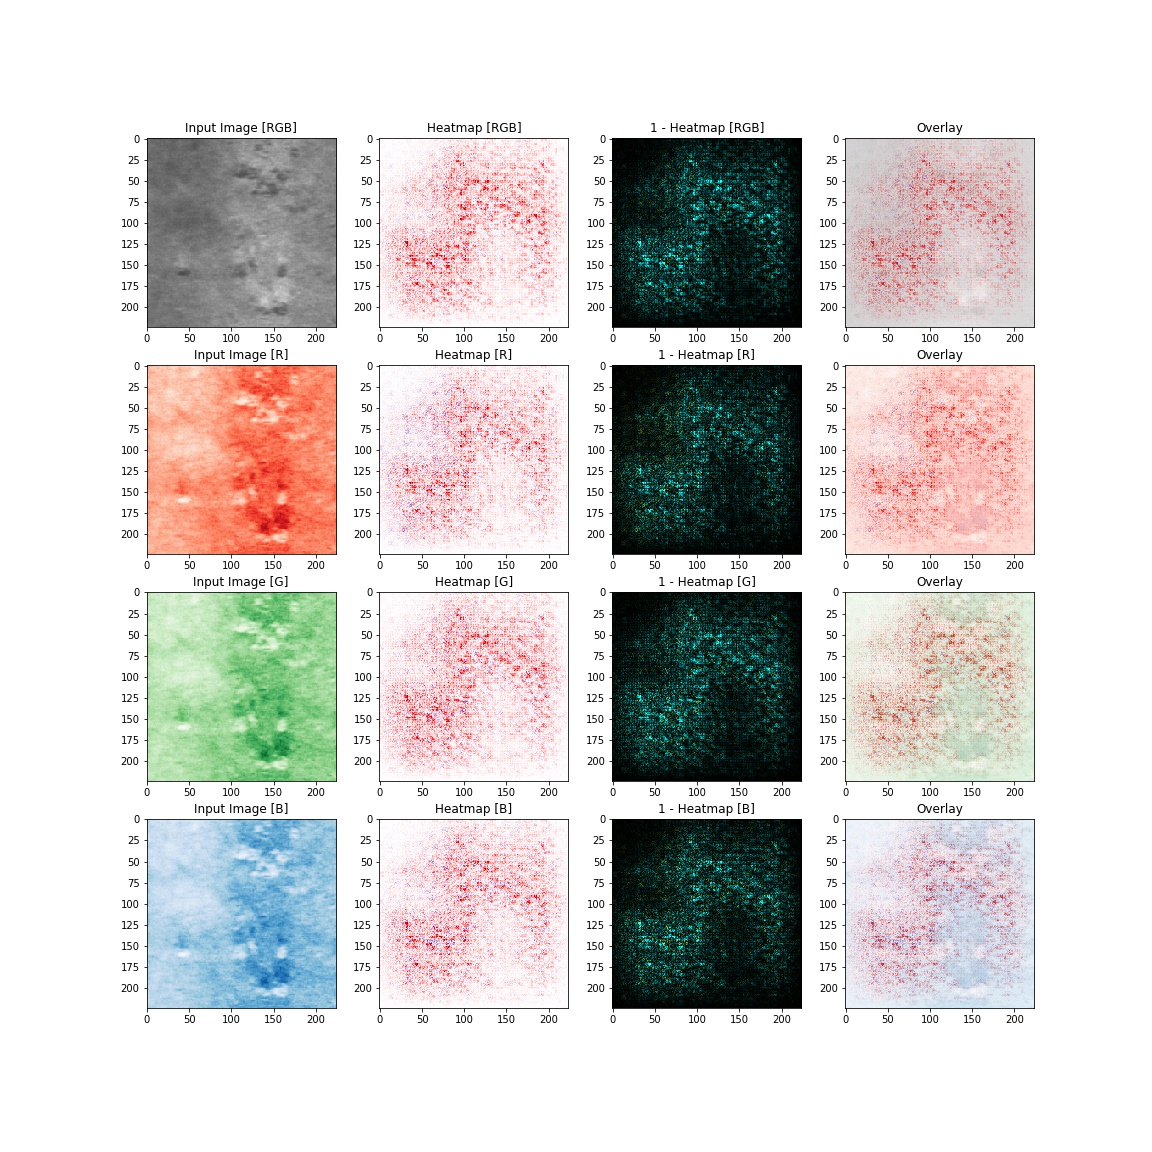

In [25]:
IPImage('/home/jupyter/results/lenet_RS_56_signals_class_0.JPEG')

#### Step 5.3 - Signal Attribution profile | Miss-classified Images

##### Example 1

In [26]:
img_path = "NEU-CLS_New/val/SC/Sc_39.bmp"

if(not os.path.exists(img_path)):
    raise FileNotFoundError(img_path)
inp_image = Image.open(img_path)
inp_image = inp_image.convert("RGB")
crop_inp_image = img_transform(inp_image)
input_tensor = tensor_transform(crop_inp_image)
input_tensor = input_tensor.unsqueeze(0)
if (torch.cuda.is_available()):
    input_tensor = input_tensor.cuda()

img_name = img_path.split('/')[-1].split('.')[0].strip()
out_prefix = os.path.join(results_path, '{}_{}_signals'.format(args.mname, img_name))
gradients = untangle_ai.attribute_signals(model_ft, input_tensor, crop_inp_image, signal_store_path, ID2Name_Map, args, out_prefix)

Top-2 class(es): ['5', '1']
Top-2 indices(s): [5, 1]
Top-2 logit(s): [4.628101, 4.454416]
Top-2 probs(s): [0.53530526, 0.449957]
----------------------------------------------------------------------
     Signal visualization for class: 5 [5]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_5.pkl
----------------------------------------------------------------------
     Signal visualization for class: 1 [1]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_1.pkl
class_0 specific heatmap saved in path: `/home/jupyter/results/resnet34_cmp_Sc_39_signals_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/resnet34_cmp_Sc_39_signals_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/resnet34_cmp_Sc_39_signals_diff_class

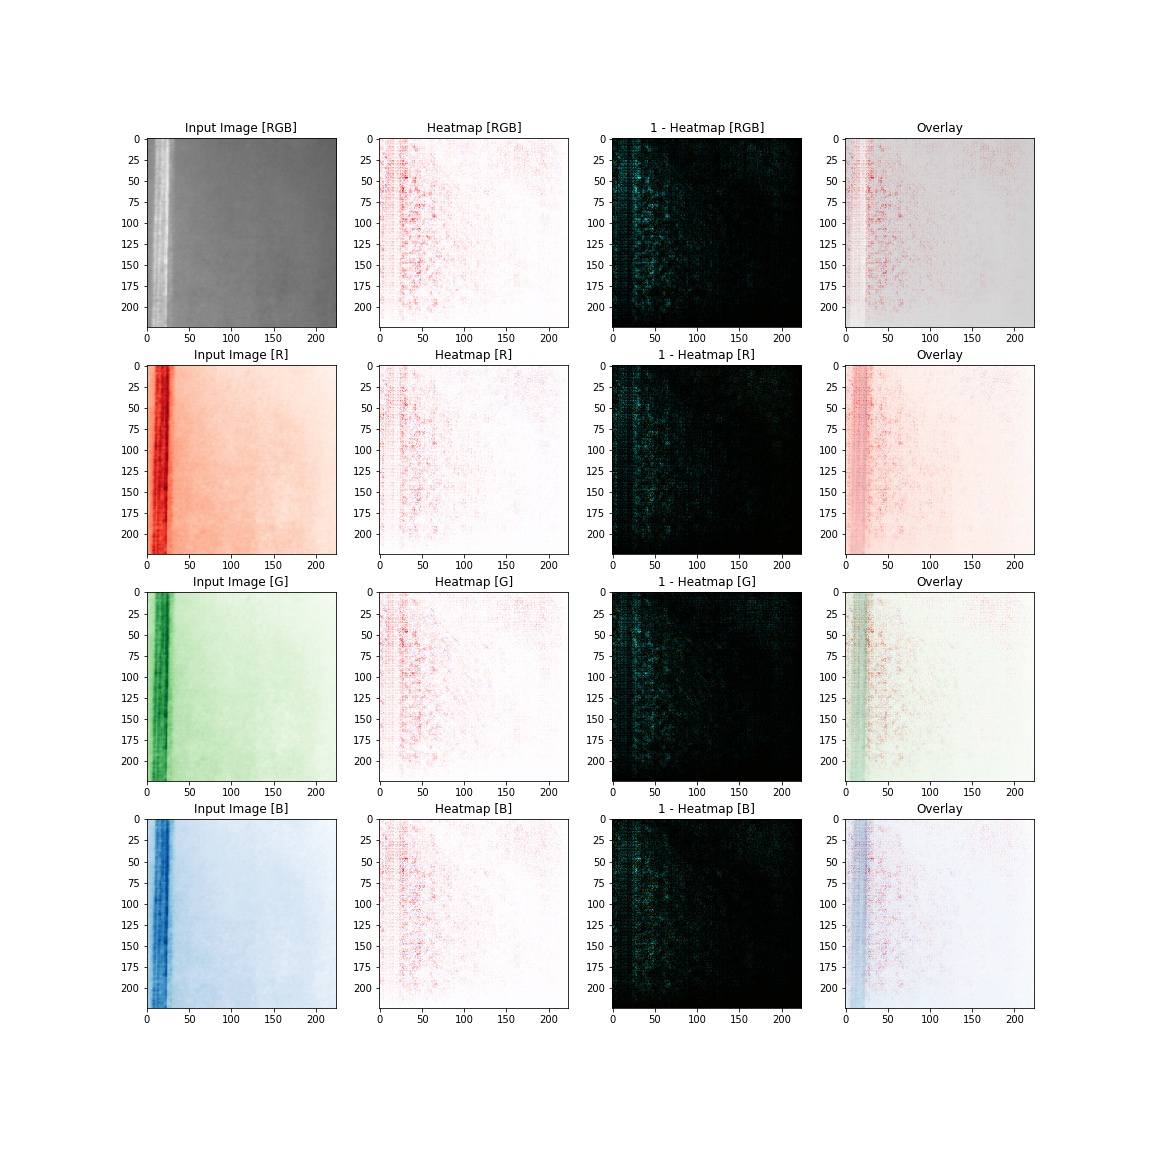

In [27]:
IPImage('/home/jupyter/results/lenet_Sc_39_signals_class_0.JPEG')

##### Example 2

In [28]:
img_path = "NEU-CLS_New/val/SC/Sc_92.bmp"

if(not os.path.exists(img_path)):
    raise FileNotFoundError(img_path)
inp_image = Image.open(img_path)
inp_image = inp_image.convert("RGB")
crop_inp_image = img_transform(inp_image)
input_tensor = tensor_transform(crop_inp_image)
input_tensor = input_tensor.unsqueeze(0)
if (torch.cuda.is_available()):
    input_tensor = input_tensor.cuda()

img_name = img_path.split('/')[-1].split('.')[0].strip()
out_prefix = os.path.join(results_path, '{}_{}_signals'.format(args.mname, img_name))
gradients = untangle_ai.attribute_signals(model_ft, input_tensor, crop_inp_image, signal_store_path, ID2Name_Map, args, out_prefix)

Top-2 class(es): ['5', '1']
Top-2 indices(s): [5, 1]
Top-2 logit(s): [6.939611, 0.8772567]
Top-2 probs(s): [0.99668235, 0.0023211855]
----------------------------------------------------------------------
     Signal visualization for class: 5 [5]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_5.pkl
----------------------------------------------------------------------
     Signal visualization for class: 1 [1]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/resnet34_cmp_signal_class_1.pkl
class_0 specific heatmap saved in path: `/home/jupyter/results/resnet34_cmp_Sc_92_signals_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/resnet34_cmp_Sc_92_signals_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/resnet34_cmp_Sc_92_signals_diff_

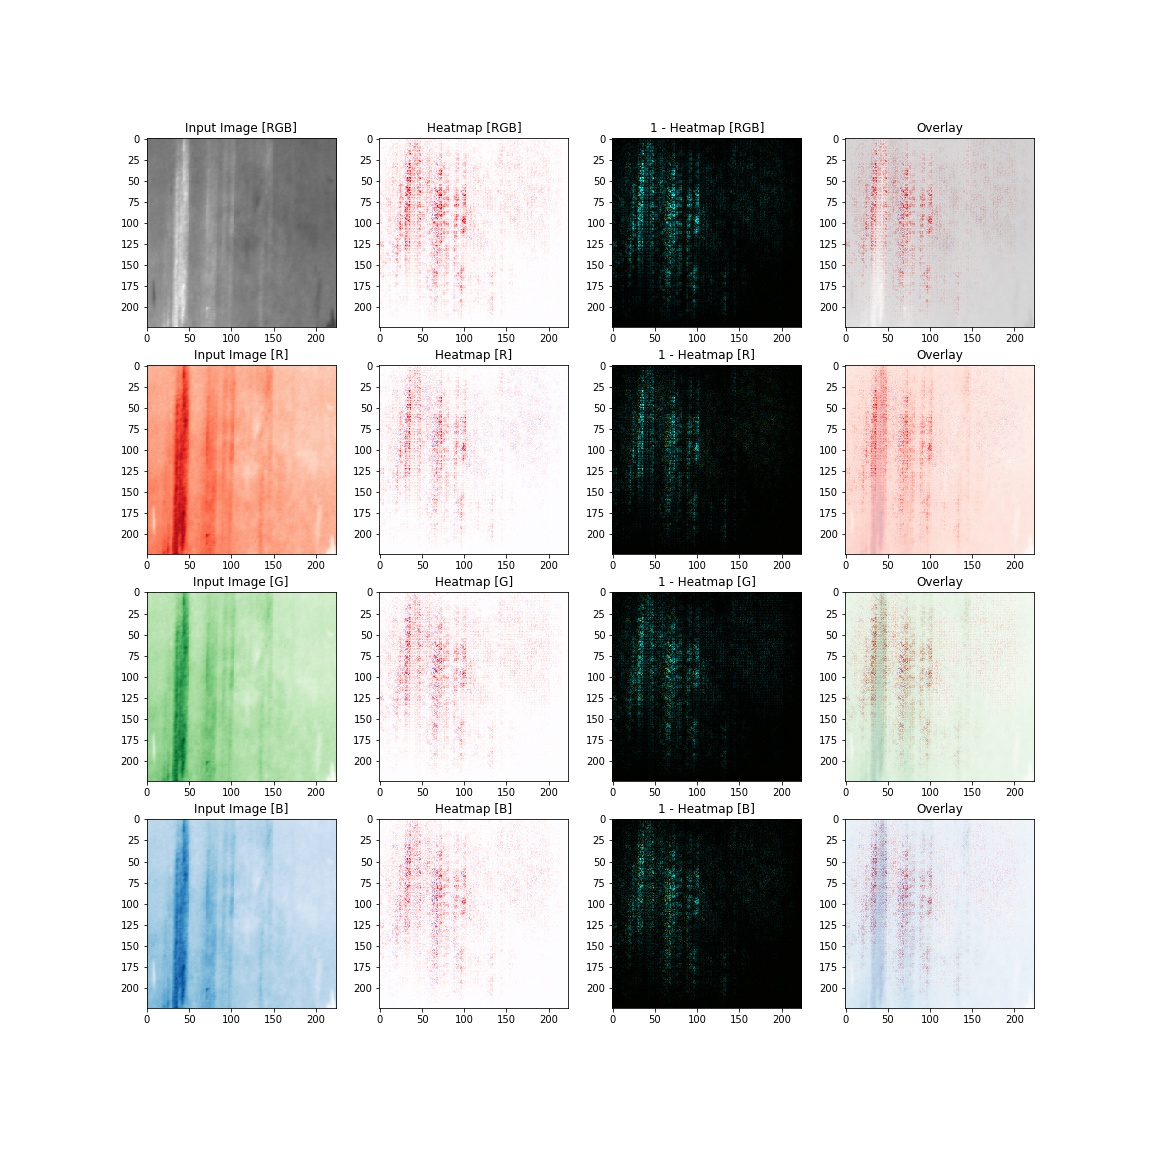

In [29]:
IPImage('/home/jupyter/results/lenet_Sc_92_signals_class_0.JPEG')

In [30]:
device = torch.device("cuda")
model_ft = model_ft.to(device)
summary(model_ft, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5            [-1, 9, 56, 56]           5,184
       BatchNorm2d-6            [-1, 9, 56, 56]              18
              ReLU-7            [-1, 9, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]           5,184
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 10, 56, 56]           5,760
      BatchNorm2d-13           [-1, 10, 56, 56]              20
             ReLU-14           [-1, 10,

#### Inference time of Compressed Resnet34

In [32]:
%%timeit
model_ft(torch.randn(1,3,224,224).cuda())

8.85 ms ± 71.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
device = torch.device("cuda")
model_ft = model_ft.to(device)
summary(model_ft, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

#### Inference time of Original Resnet34

In [33]:
model_ft = models.resnet34(pretrained= False)
model_wt = torch.load('NEU_Surface_Crack_full_Resnet34_with_contrast_enhancement_and_neg_level5.pth')
model_ft.fc = nn.Linear(512, 6)
model_ft.load_state_dict(model_wt)
model_ft = model_ft.eval()
model_ft = model_ft.cuda()

In [34]:
%%timeit
model_ft(torch.randn(1,3,224,224).cuda())

13.4 ms ± 5.02 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Validation accuracy of Original Resnet34

In [36]:
model_ft = models.resnet34(pretrained= False)
model_wt = torch.load('NEU_Surface_Crack_full_Resnet34_with_contrast_enhancement_and_neg_level5.pth')
model_ft.fc = nn.Linear(512, 6)
model_ft.load_state_dict(model_wt)
model_ft = model_ft.eval()
model_ft = model_ft.cuda()

dataroot = 'NEU-CLS_New/val'
val_dataset = datasets.ImageFolder(dataroot, data_transforms['val'])
dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

model_ft = model_ft.eval()
running_corrects = 0.0
total = 0.0
for input_tensor, target in dataloader:
    input_tensor = input_tensor.cuda()
    target = target.cuda()
    output = model_ft(input_tensor)
    preds = torch.max(output, 1)[1]
    correct = torch.sum(preds == target.data)
    running_corrects += correct
    total += input_tensor.shape[0]
    print("running corrects: {}/{}".format(correct, input_tensor.shape[0]))
    
print("Total corrects: {}/{}".format(running_corrects, total))

running corrects: 127/128
running corrects: 126/128
running corrects: 125/128
running corrects: 60/66
Total corrects: 438/450.0


#### Validation accuracy of compressed Resnet34

In [38]:
model_ft = torch.load('Channel_Pruned_0.99_NEU_CLS_no_accuracy_drop.pkl')
model_ft = model_ft.eval()
if (torch.cuda.is_available()):
    model_ft = model_ft.cuda() 
    
dataroot = 'NEU-CLS_New/val'
val_dataset = datasets.ImageFolder(dataroot, data_transforms['val'])
dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

model_ft = model_ft.eval()
running_corrects = 0.0
total = 0.0
for input_tensor, target in dataloader:
    input_tensor = input_tensor.cuda()
    target = target.cuda()
    output = model_ft(input_tensor)
    preds = torch.max(output, 1)[1]
    correct = torch.sum(preds == target.data)
    running_corrects += correct
    total += input_tensor.shape[0]
    print("running corrects: {}/{}".format(correct, input_tensor.shape[0]))
    
print("Total corrects: {}/{}".format(running_corrects, total))

running corrects: 128/128
running corrects: 125/128
running corrects: 123/128
running corrects: 52/66
Total corrects: 428/450.0


#### Integrated Gradients on Compressed Resnet34

##### Example 1

In [45]:
class IntegratedArgs:
    mname = 'resnet34_cmp'
    img_size = (3,224,224)
    num_classes = 6
    method = 'integratedGrad' # one of `vanillaGrad`, `deConvNet`, `guided_bp`, `gradcam`, `saliencyGrad`, `integratedGrad` `smoothgrad`
    topk = 2
    cmap = 'seismic'
    json = False
    hm_diff = 'joint'
    steps = 50 # only for integrated gradients
    baseline = None # torch tensor (of shape `input_tensor`) only for integrated gradients

intArgs = IntegratedArgs()

img_path = "NEU-CLS_New/val/Rs/RS_32.bmp"
inp_image = Image.open(img_path)
inp_image = inp_image.convert("RGB")
crop_inp_image = img_transform(inp_image)
input_tensor = tensor_transform(crop_inp_image)
input_tensor = input_tensor.unsqueeze(0)
if (torch.cuda.is_available()):
    input_tensor = input_tensor.cuda()
out_prefix = os.path.join(results_path, '{}_{}'.format(intArgs.mname, intArgs.method))

In [46]:
untangle_ai.integratedGrad(model_ft, input_tensor, crop_inp_image, out_prefix, intArgs)

Top-2 class(es): ['4', '2']
Top-2 logit(s): [6.417037, 1.2531148]
Top-2 probs(s): [0.99292374, 0.0056787524]
class_0 specific heatmap saved in path: `/home/jupyter/results/resnet34_cmp_integratedGrad_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/resnet34_cmp_integratedGrad_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/resnet34_cmp_integratedGrad_diff_class_1.JPEG`
class_1 specific invDiff heatmap saved in path: `/home/jupyter/results/resnet34_cmp_integratedGrad_invDiff_class_1.JPEG`


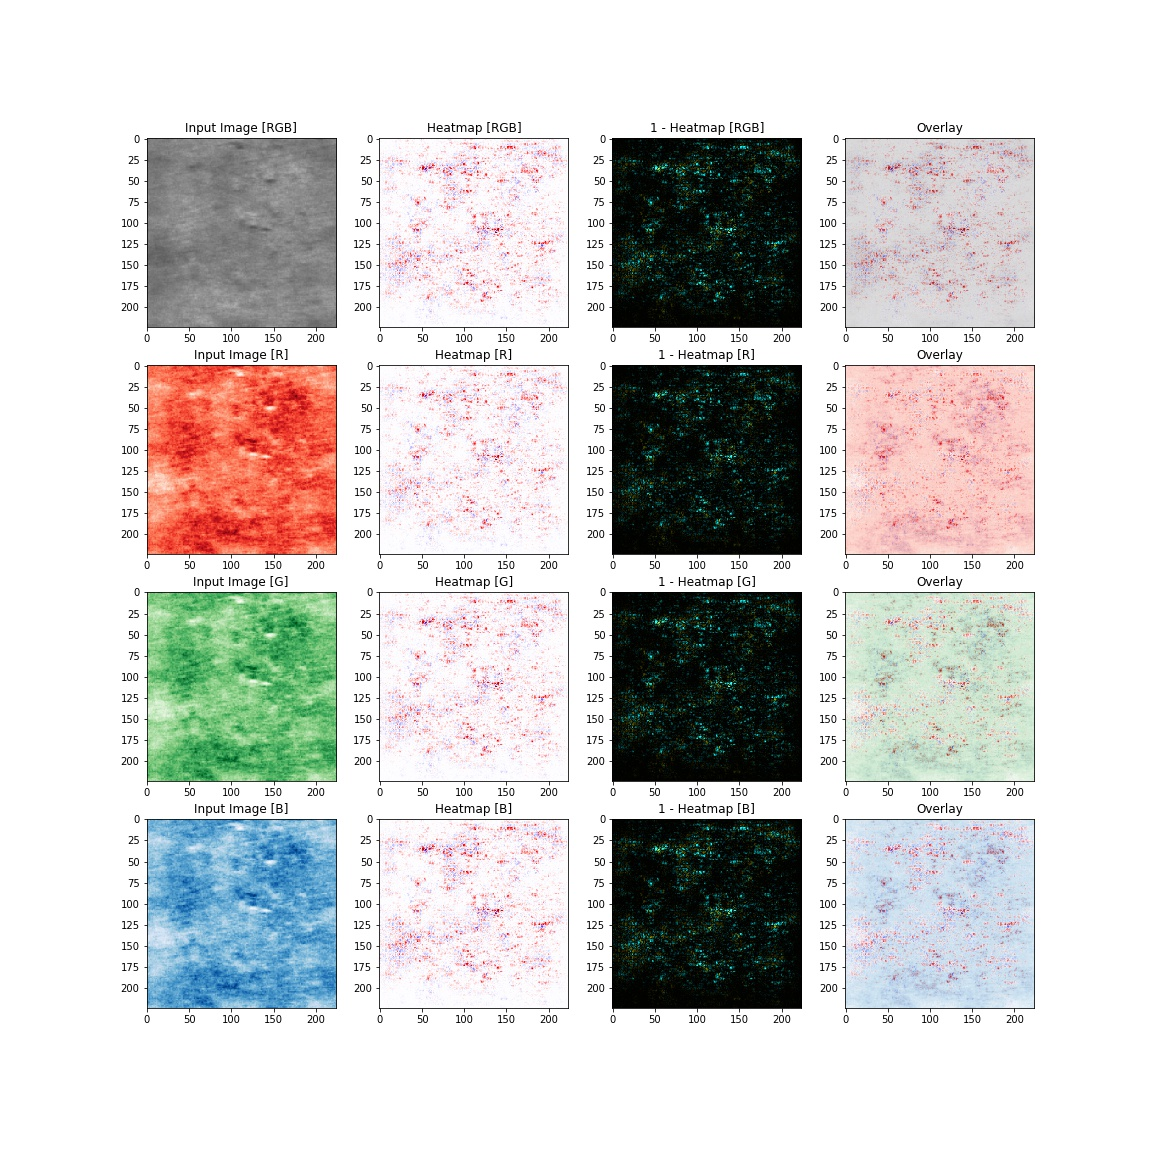

In [47]:
IPImage('/home/jupyter/results/resnet34_cmp_integratedGrad_class_0.JPEG')

##### Example 2

In [49]:
img_path = "NEU-CLS_New/val/SC/Sc_92.bmp"
inp_image = Image.open(img_path)
inp_image = inp_image.convert("RGB")
crop_inp_image = img_transform(inp_image)
input_tensor = tensor_transform(crop_inp_image)
input_tensor = input_tensor.unsqueeze(0)
if (torch.cuda.is_available()):
    input_tensor = input_tensor.cuda()
out_prefix = os.path.join(results_path, '{}_{}'.format(intArgs.mname, intArgs.method))

In [50]:
untangle_ai.integratedGrad(model_ft, input_tensor, crop_inp_image, out_prefix, intArgs)

Top-2 class(es): ['5', '1']
Top-2 logit(s): [6.939611, 0.8772567]
Top-2 probs(s): [0.99668235, 0.0023211855]
class_0 specific heatmap saved in path: `/home/jupyter/results/resnet34_cmp_integratedGrad_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/resnet34_cmp_integratedGrad_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/resnet34_cmp_integratedGrad_diff_class_1.JPEG`
class_1 specific invDiff heatmap saved in path: `/home/jupyter/results/resnet34_cmp_integratedGrad_invDiff_class_1.JPEG`


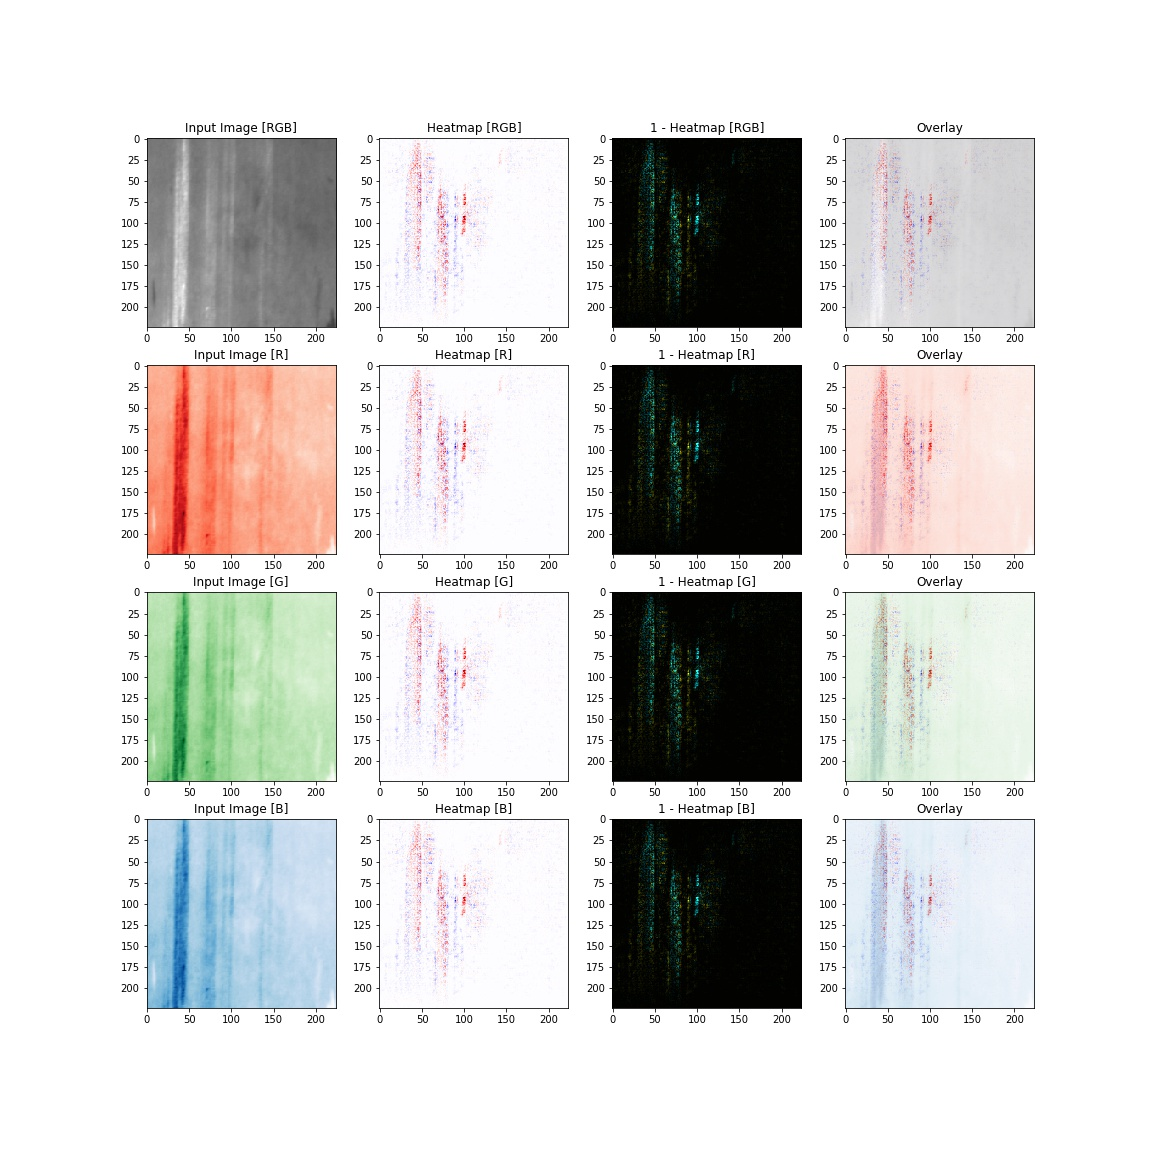

In [51]:
IPImage('/home/jupyter/results/resnet34_cmp_integratedGrad_class_0.JPEG')